# EDA: Startup Funding Analysis
- **Author**: Ekaterina Kemenova
- **Date**: 10.11.2025

## 0.1 Project goals and objectives

**Goal:**  
Conduct an exploratory analysis of the dynamics and structure of startup funding using historical data, in order to assess investment opportunities and inform a hypothetical market entry and company acquisition strategy.

**Context:**
A financial company operating in the venture capital space seeks to understand historical patterns in startup funding in order to evaluate potential market entry through company acquisition and development.

**Key objectives:**
- Load and explore the structure of datasets;
- Clean and prepare the data (handle missing values, duplicates, incorrect data types);
- Segment companies by funding timeline and compare investment volume and company counts;
- Classify market segments into mass, mid-size, and niche categories;
- Identify typical and anomalous funding amounts and remove outliers;
- Compare popularity and funding volumes of different funding types;
- Analyze the dynamics of funding rounds and investment volumes over time;
- Calculate return shares by funding type and assess their stability;
- Summarize findings and provide data-driven recommendations.
---

## 0.2 Data description

The analysis is based on two datasets obtained from a startup investment database:

**cb_investments.csv** — the main dataset containing company-level information and detailed historical data on startup funding:

- `name` — company name  
- `homepage_url` — company website URL  
- `category_list` — categories the company operates in (separated by `|`)  
- `market` — primary market or industry  
- `funding_total_usd` — total funding raised (USD)  
- `status` — current company status (e.g., *operating*, *closed*)  
- `country_code` — country code (e.g., *USA*)  
- `state_code` — state or regional code (e.g., *CA*)  
- `region` — geographic region (e.g., *SF Bay Area*)  
- `city` — city where the company is located  
- `funding_rounds` — total number of funding rounds  
- `participants` — number of investors involved  
- `founded_at` — company founding date  
- `founded_month` — founding month (YYYY-MM)  
- `founded_quarter` — founding quarter (YYYY-QN)  
- `founded_year` — founding year  
- `first_funding_at` — date of the first funding round  
- `mid_funding_at` — date of the midpoint funding round (by time)  
- `last_funding_at` — date of the most recent funding round  
- `seed`, `venture`, `angel`, `grant`, `debt_financing`, `convertible_note`, `private_equity`,  
  `equity_crowdfunding`, `product_crowdfunding`, `undisclosed`,  
  `post_ipo_equity`, `post_ipo_debt`, `secondary_market` — funding amounts by investment type  
- `round_A` – `round_H` — funding amounts raised in corresponding investment rounds  

**cb_returns.csv** — a dataset containing annual return amounts by funding type, reported in millions of USD:

- `year` — year of returns  
- `seed`, `venture`, `angel`, `grant`, `debt_financing`, `convertible_note`,  
  `private_equity`, `equity_crowdfunding`, `product_crowdfunding`,  
  `undisclosed`, `post_ipo_equity`, `post_ipo_debt`, `secondary_market` — return amounts by investment type (USD, millions)  

## 0.3 Project structure

1. [Data overview and preprocessing](#data-overview-and-preprocessing)
2. [Feature engineering](#feature-engineering)
3. [Outlier detection and analysis](#outlier-detection-and-analysis)
4. [Trend and dynamics analysis](#trend-and-dynamics-analysis)
5. [Final conclusions and recommendations](#final-conclusions-and-recommendations)

<a id='data-overview-and-preprocessing'></a>
## Data overview and preprocessing

### 1.1. Data overview

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df_investments = pd.read_csv("cb_investments.zip", sep=';', low_memory=False)
df_returns = pd.read_csv("cb_returns.csv")

In [3]:
def review_data(df):
    print('General dataset information:')
    df.info()
    
    print('\nFirst 5 rows of the dataset:')
    display(df.head())
    
    missing_summary = pd.DataFrame({
        'missing_count': df.isna().sum(),
        'missing_share': df.isna().mean()
    }).sort_values(by='missing_count', ascending=False)
    
    print('\nMissing values summary:')
    display(missing_summary)
    
    print('\nNumber of duplicate rows:')
    print(df.duplicated().sum())
    
    print('\nDescriptive statistics for numerical columns:')
    display(df.describe())

In [4]:
review_data(df_investments)

General dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54294 entries, 0 to 54293
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  49437 non-null  object 
 1   homepage_url          45989 non-null  object 
 2   category_list         45477 non-null  object 
 3    market               45477 non-null  object 
 4    funding_total_usd    49438 non-null  object 
 5   status                48124 non-null  object 
 6   country_code          44165 non-null  object 
 7   state_code            30161 non-null  object 
 8   region                44165 non-null  object 
 9   city                  43322 non-null  object 
 10  funding_rounds        49438 non-null  float64
 11  participants          30473 non-null  float64
 12  founded_at            38554 non-null  object 
 13  founded_month         38482 non-null  object 
 14  founded_quarter       38482 non-null  obj

,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,Harvard University,http://harvard.edu,|Education|,Education,"9,00,00,000",operating,USA,MA,Boston,Cambridge,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,University of New Brunswick,http://www.unb.ca,NaN,NaN,"20,00,000",operating,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,DuPont,http://www.dupont.com,|Business Services|Agriculture|Automotive|Inve...,Business Services,"90,00,000",operating,USA,DE,"Wilmington, Delaware",Wilmington,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,University of Michigan,http://www.umich.edu/,|Education|,Education,"77,00,000",operating,USA,MI,Detroit,Ann Arbor,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Case Western Reserve University,http://www.case.edu,|Education|,Education,"5,40,000",operating,USA,OH,Cleveland,Cleveland,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Missing values summary:


,missing_count,missing_share
state_code,24133,0.444487
mid_funding_at,24006,0.442148
participants,23821,0.438741
founded_month,15812,0.291229
founded_quarter,15812,0.291229
founded_at,15740,0.289903
founded_year,15740,0.289903
city,10972,0.202085
country_code,10129,0.186558
region,10129,0.186558



Number of duplicate rows:
4855

Descriptive statistics for numerical columns:


,funding_rounds,participants,founded_year,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,...,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
count,49438.000000,30473.000000,38554.000000,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,...,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04,4.943800e+04
mean,1.696205,1.451646,2007.094231,2.173215e+05,7.501051e+06,6.163322e+03,1.302213e+05,2.336410e+04,1.888157e+06,6.541898e+04,...,3.845592e+04,7.074227e+03,1.243955e+06,1.492891e+06,1.205356e+06,7.375261e+05,3.424682e+05,1.697692e+05,5.767067e+04,1.423197e+04
std,1.294213,2.022233,9.862177,1.056985e+06,2.847112e+07,1.999048e+05,2.981404e+06,1.432046e+06,1.382046e+08,6.582908e+05,...,3.864461e+06,4.282166e+05,5.531974e+06,7.472704e+06,7.993592e+06,9.815218e+06,5.406915e+06,6.277905e+06,5.252312e+06,2.716865e+06
min,1.000000,0.000000,1636.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000,0.000000,2005.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000,1.000000,2010.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000,2.000000,2012.000000,2.500000e+04,5.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,18.000000,36.000000,2014.000000,1.300000e+08,2.351000e+09,2.500000e+07,2.924328e+08,3.000000e+08,3.007950e+10,6.359026e+07,...,6.806116e+08,7.200000e+07,3.190000e+08,5.420000e+08,4.900000e+08,1.200000e+09,4.000000e+08,1.060000e+09,1.000000e+09,6.000000e+08


In [5]:
review_data(df_returns)

General dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  15 non-null     int64  
 1   seed                  15 non-null     float64
 2   venture               15 non-null     float64
 3   equity_crowdfunding   15 non-null     float64
 4   undisclosed           15 non-null     float64
 5   convertible_note      15 non-null     float64
 6   debt_financing        15 non-null     float64
 7   angel                 15 non-null     float64
 8   grant                 15 non-null     float64
 9   private_equity        15 non-null     float64
 10  post_ipo_equity       15 non-null     float64
 11  post_ipo_debt         15 non-null     float64
 12  secondary_market      15 non-null     float64
 13  product_crowdfunding  15 non-null     float64
dtypes: float64(13), int64(1)
memory usage: 1.8 KB



,year,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding
0,2000,16.70,55.40,0.0,78.21,0.00,8.66,6.43,0.0,0.00,0.94,0.0,0.20,0.0
1,2001,2.88,23.49,0.0,21.50,0.01,4.49,1.18,0.0,0.00,0.46,0.0,0.46,0.0
2,2002,6.59,209.42,0.0,25.77,0.02,3.42,3.41,0.0,1.51,0.34,0.0,0.06,0.0
3,2003,7.74,233.86,0.0,9.40,0.01,1.09,3.41,0.0,1.62,2.11,0.0,0.08,0.0
4,2004,9.93,555.90,0.0,33.19,0.01,13.55,9.18,0.0,2.19,3.38,0.0,0.55,0.0



Missing values summary:


,missing_count,missing_share
year,0,0.0
seed,0,0.0
venture,0,0.0
equity_crowdfunding,0,0.0
undisclosed,0,0.0
convertible_note,0,0.0
debt_financing,0,0.0
angel,0,0.0
grant,0,0.0
private_equity,0,0.0



Number of duplicate rows:
0

Descriptive statistics for numerical columns:


,year,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.0,15.000000,15.000000,15.000000,15.000000,15.000000
mean,2007.000000,158.816000,2705.241333,0.255333,48.725333,2.319333,315.656667,100.615333,0.0,239.155333,73.664000,6.068667,0.346667,0.124000
std,4.472136,180.020855,2206.926388,0.391825,27.826630,2.496527,345.365979,95.502534,0.0,324.392213,86.990707,12.483043,0.296303,0.208286
min,2000.000000,2.880000,23.490000,0.000000,9.400000,0.000000,1.090000,1.180000,0.0,0.000000,0.340000,0.000000,0.050000,0.000000
25%,2003.500000,13.315000,394.880000,0.000000,29.480000,0.015000,11.105000,7.805000,0.0,1.905000,2.745000,0.000000,0.120000,0.000000
50%,2007.000000,70.410000,2717.020000,0.030000,46.740000,1.780000,125.680000,97.210000,0.0,88.810000,24.360000,0.000000,0.200000,0.000000
75%,2010.500000,291.310000,3752.375000,0.345000,65.200000,3.590000,538.325000,168.340000,0.0,361.545000,122.365000,1.520000,0.510000,0.250000
max,2014.000000,530.750000,7272.010000,1.150000,105.720000,7.870000,1017.750000,293.980000,0.0,988.530000,262.700000,37.200000,1.030000,0.720000


In [6]:
initial_row_count = df_investments.shape[0]
initial_row_count

54294

The `cb_investments.csv` dataset contains **40 columns** and **54,294 rows**. The data matches the description. 
- Column names accurately reflect the data content but require minor cleanup to remove extra whitespace. 
- The `funding_total_usd` column should be converted to a numeric data type. 
- Date-related fields should be cast to `datetime64`, including `founded_at`, `founded_month`, `founded_quarter`, `founded_year`, `first_funding_at`, `mid_funding_at`, and `last_funding_at`. 
- All remaining columns use appropriate data types. 
- Missing values are present across all columns.

The `cb_returns.csv` dataset contains **14 columns** and **15 rows**. The data is consistent with the description, column names are clear, and data types are appropriate. No missing values are present.

### 1.2. Data cleaning and preparation

Removing extra whitespace from column names:

In [7]:
df_investments.columns = df_investments.columns.str.strip()

In [8]:
df_investments.columns

Index(['name', 'homepage_url', 'category_list', 'market', 'funding_total_usd',
       'status', 'country_code', 'state_code', 'region', 'city',
       'funding_rounds', 'participants', 'founded_at', 'founded_month',
       'founded_quarter', 'founded_year', 'first_funding_at', 'mid_funding_at',
       'last_funding_at', 'seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H'],
      dtype='object')

Removing thousand separators from `funding_total_usd` and converting it to a numeric type:

In [9]:
df_investments['funding_total_usd'] = pd.to_numeric(df_investments['funding_total_usd'].str.replace(',', ''), errors='coerce')

Converting date-related fields to datetime64:

In [10]:
for column in ['founded_at','first_funding_at','mid_funding_at','last_funding_at','founded_month','founded_quarter','founded_year']:
    df_investments[column] = pd.to_datetime(df_investments[column],errors='coerce')

In [11]:
df_investments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54294 entries, 0 to 54293
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   name                  49437 non-null  object        
 1   homepage_url          45989 non-null  object        
 2   category_list         45477 non-null  object        
 3   market                45477 non-null  object        
 4   funding_total_usd     40907 non-null  float64       
 5   status                48124 non-null  object        
 6   country_code          44165 non-null  object        
 7   state_code            30161 non-null  object        
 8   region                44165 non-null  object        
 9   city                  43322 non-null  object        
 10  funding_rounds        49438 non-null  float64       
 11  participants          30473 non-null  float64       
 12  founded_at            38553 non-null  datetime64[ns]
 13  founded_month   

In [12]:
df_returns = df_returns.set_index('year')

We clean text data and fill missing values in categorical columns with placeholders:

In [13]:
 for column in df_investments.columns:
        if df_investments[column].dtype == 'object':
            df_investments[column] = df_investments[column].str.strip().str.lower()

In [14]:
for column in ['category_list','market','status']:
    df_investments[column] = df_investments[column].fillna('unknown')

We check for duplicates and remove them:

In [15]:
duplicates = df_investments.duplicated().sum()
duplicates

4855

In [16]:
df_returns.duplicated().sum()

0

In [17]:
df_investments = df_investments.drop_duplicates()

In [18]:
df_investments.duplicated(subset=['name','funding_total_usd']).sum()

14

In [19]:
df_investments = df_investments.drop_duplicates(subset=['name','funding_total_usd'])

We remove missing values from the `funding_total_usd` column:

In [20]:
funding_total_na = df_investments['funding_total_usd'].isna().sum()
funding_total_na

8529

In [21]:
df_investments = df_investments.dropna(subset=['funding_total_usd'])

We fill missing values in the `mid_funding_at` column based on the `first_funding_at` and `last_funding_at` fields. As a new value, we take an approximate midpoint between these two dates.

In [22]:
middle_interval = (df_investments['last_funding_at'] - df_investments['first_funding_at']) / 2
df_investments['mid_funding_at'] = df_investments['mid_funding_at'].fillna(df_investments['first_funding_at'] + middle_interval)

In [23]:
missing_summary = pd.DataFrame({
    'missing_count': df_investments.isna().sum(),
    'missing_share': df_investments.isna().mean()
}).sort_values(by='missing_count', ascending=False)

missing_summary

,missing_count,missing_share
state_code,15283,0.373704
participants,13570,0.331817
founded_month,8767,0.214373
founded_quarter,8767,0.214373
founded_at,8702,0.212784
founded_year,8701,0.212759
city,4502,0.110084
country_code,3816,0.093310
region,3816,0.093310
homepage_url,2313,0.056558


In [24]:
deleted_rows = initial_row_count - df_investments.shape[0]
deleted_rows_share = deleted_rows / initial_row_count * 100
deleted_rows_share

24.676759862968282

In [25]:
duplicates_share = duplicates / initial_row_count * 100
duplicates_share

8.942056212472833

In [26]:
funding_total_na_share = funding_total_na / initial_row_count * 100
funding_total_na_share

15.708918112498619

During data preprocessing, approximately **25% of rows** were removed from the `cb_investments.csv` dataset. Of these, **9%** were duplicate records and **16%** were rows with missing funding information (`funding_total_usd`). Since `funding_total_usd` is a key variable for this analysis, removing rows with missing values in this column is justified. All rows in the `cb_returns.csv` dataset were retained.

After cleaning, some missing values remain in `cb_investments.csv`. The highest share of missing data is observed in geographic fields (`state_code` — 37%, likely due to non-US companies; `city` — 11%, `country_code` — 9%, `region` — 9%), company founding date fields (`founded_month`, `founded_quarter`, `founded_at`, `founded_year` — ~21% each), as well as in `participants` (33%) and `homepage_url` (5%). These variables are not critical for the current analysis, so the remaining missing values were left as is.

Overall, the available data is sufficient to address the project objectives.

<a id='feature-engineering'></a>
## 2. Feature engineering

### 2.1. Company groups by funding timeline

We segment companies into three groups and visualize their proportions:

- **Single funding round** — companies with only one funding round.
- **Short funding cycle (≤ 1 year)** — the time between the first and last funding rounds does not exceed one year.
- **Long funding cycle (> 1 year)** — companies that raised funding over a period longer than one year.

In [27]:
def categorize (row):
    if row['funding_rounds'] == 1:
        return 'Single funding round'
    elif row['last_funding_at'] - row['first_funding_at'] <= pd.to_timedelta('365 days'):
        return 'Short funding cycle'
    elif row['last_funding_at'] - row['first_funding_at'] > pd.to_timedelta('365 days'):
        return 'Long funding cycle'

df_investments['funding_category'] = df_investments.apply(categorize, axis=1)

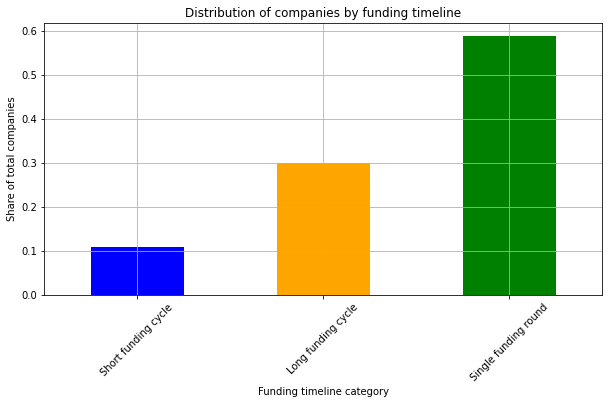

In [28]:
plt.figure (figsize = (10,5))
df_investments['funding_category'].value_counts(normalize=True).sort_values(ascending=True).plot(
                kind='bar',
                title='Distribution of companies by funding timeline',
                rot=45,
                legend=False,
                color=['blue', 'orange', 'green'])
plt.xlabel('Funding timeline category')
plt.ylabel('Share of total companies')
plt.grid()
plt.show()

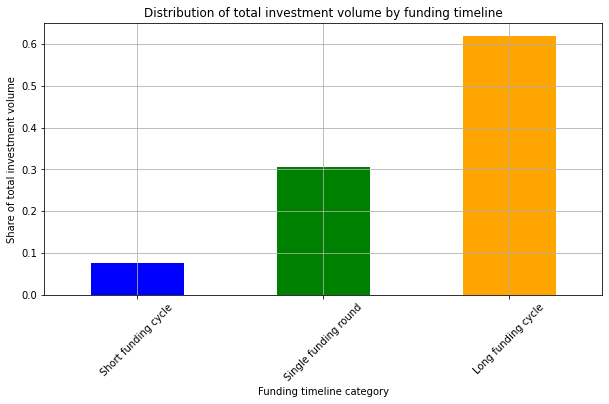

In [29]:
total_funding = df_investments['funding_total_usd'].sum()
total_funding_share = df_investments.groupby('funding_category')['funding_total_usd'].sum() / total_funding
total_funding_share

plt.figure (figsize = (10,5))
total_funding_share.sort_values(ascending=True).plot(
                kind='bar',
                title='Distribution of total investment volume by funding timeline',
                rot=45,
                legend=False,
                color=['blue', 'green', 'orange'])
plt.xlabel('Funding timeline category')
plt.ylabel('Share of total investment volume')
plt.grid()
plt.show()

More than half of all companies (around 60%) have received only a single round of funding. Companies funded for more than one year represent 30% of the sample, while short-term funded companies (up to one year) account for 10%.

However, the majority of investment capital is concentrated in companies with longer funding timelines: companies funded for more than one year capture over 60% of total investment volume, compared to ~30% for single-round companies and <10% for short-term funded firms.

### 2.2 Market segmentation into mass, mid-size, and niche segments

To assess market structure, segments are grouped by company count: 
- **mass segments** include more than 120 companies
- **mid-size segments** include 35–120 companies
- **niche segments** include fewer than 35 companies

In [30]:
df_market_counts = df_investments['market'].value_counts().sort_values(ascending=False).reset_index()
df_market_counts.columns = ['market','count']
df_market_counts.head(11)

,market,count
0,software,4812
1,biotechnology,3590
2,unknown,2499
3,mobile,2343
4,e-commerce,1866
5,curated web,1691
6,enterprise software,1381
7,health care,1185
8,clean technology,1180
9,games,1117


In [31]:
df_market_counts['market_segment'] = pd.cut(df_market_counts['count'], bins=[0,35,120,5000], labels=['niche','mid','mass'])

In [32]:
df_investments = df_investments.merge(df_market_counts[['market','market_segment']], how='left', on='market')

In [33]:
df_investments['market_segment'].value_counts().sort_values(ascending=False)

mass     36228
mid       3839
niche      829
Name: market_segment, dtype: int64

In [34]:
df_investments['market_segment'].value_counts(normalize=True).sort_values(ascending=False)

mass     0.885857
mid      0.093872
niche    0.020271
Name: market_segment, dtype: float64

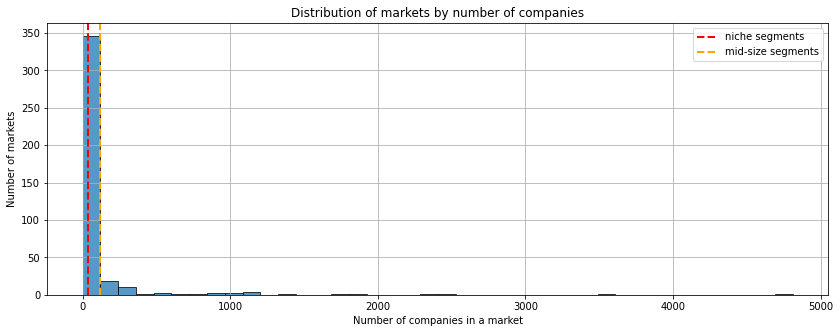

In [35]:
plt.figure (figsize = (14,5))
df_investments['market'].value_counts().sort_values(ascending=True).plot(
        kind='hist',
        bins=40,
        alpha=0.75,
        edgecolor='black',
        rot=0,
        label='_nolegend_')

plt.axvline(35,
            color='red',
            linestyle='--',
            linewidth=2,
            label='niche segments')
plt.axvline(120,
            color='orange',
            linestyle='--',
            linewidth=2,
            label='mid-size segments')

plt.title('Distribution of markets by number of companies')
plt.xlabel('Number of companies in a market')
plt.ylabel('Number of markets')
plt.legend()
plt.grid()
plt.show()

To simplify further analysis, we keep only mass-market segments in the `market` column. All other segments are replaced with placeholders: `niche` for niche segments and `mid` for mid-size segments.

In [36]:
def replace_market (row):
    if row['market_segment'] == 'mass':
        return row['market']
    elif row['market_segment'] == 'mid':
        return 'mid'
    elif row['market_segment'] == 'niche':
        return 'niche'

df_investments['market'] = df_investments.apply(replace_market, axis=1)

The top 10 largest markets by number of companies are **software** (4,812), **biotechnology** (3,590), **mobile** (2,343), **e-commerce** (1,866), **curated web** (1,691), **enterprise software** (1,381), **health care** (1,185), **clean technology** (1,180), **games** (1,117), and **advertising** (1,107).

Segmenting markets into mass, mid-size, and niche categories shows a **strong concentration of companies in mass markets (36,228 companies)**. Mid-size markets include 3,839 companies, while niche markets account for 829 companies. This indicates that the startup ecosystem is highly concentrated in a relatively small number of large markets.

The distribution of markets by number of companies is highly asymmetric and right-skewed. While most markets (approximately 350) contain relatively few companies (fewer than 120), a small number of markets belonging to the mass segment capture a disproportionate share of total companies.

<a id='outlier-detection-and-analysis'></a>
## 3. Outlier detection and analysis

### 3.1. Outlier detection by market segment

We analyze the distribution of total funding per company in order to distinguish typical funding levels from outliers within each segment:

In [37]:
df_investments['funding_total_usd'].describe()

count    4.089600e+04
mean     1.590922e+07
std      1.686958e+08
min      1.000000e+00
25%      3.500000e+05
50%      2.000000e+06
75%      1.000000e+07
max      3.007950e+10
Name: funding_total_usd, dtype: float64

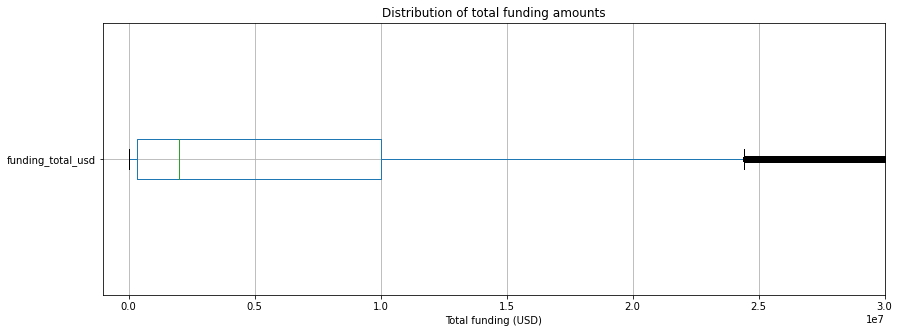

In [38]:
plt.figure (figsize = (14,5))
df_investments.boxplot(column='funding_total_usd', vert=False)
plt.title('Distribution of total funding amounts')
plt.xlim(-1000000, 30000000)
plt.xlabel('Total funding (USD)')
plt.show()

Typical values of total funding range from **USD 350,000** to **USD 24,000,000**.

The distribution of total funding is highly right-skewed, with numerous upper-end outliers: a small number of companies raised billions, whereas most companies attracted less than **USD 24,000,000**.

Given the presence of outliers, the **median** is the most reliable measure of central tendency. The median funding amount is **USD 2,000,000**.

We identify companies with anomalously high total funding and determine the market segments with the highest share of companies that received anomalous funding:

In [39]:
Q1 = df_investments.groupby('market')['funding_total_usd'].quantile(0.25)
Q3 = df_investments.groupby('market')['funding_total_usd'].quantile(0.75)

IQR = Q3 - Q1

upper_limit = (Q3 + IQR*1.5).reset_index()
lower_limit = Q1 - IQR*1.5

upper_limit.columns = ['market','market_upper_limit']

df_investments = df_investments.merge(upper_limit, on='market', how='left')

In [40]:
def categorize_outliers (row):
    if row['funding_total_usd'] > row['market_upper_limit']:
        return 1
    else:
        return 0
    
df_investments['is_outlier'] = df_investments.apply(categorize_outliers, axis=1)

In [41]:
outliers_share = df_investments.groupby('market')['is_outlier'].mean()
outliers_share.sort_values(ascending=False).head(10)

market
real estate        0.172043
entertainment      0.166667
consulting         0.166189
search             0.164948
cloud computing    0.164474
saas               0.161765
photography        0.161765
technology         0.159664
video              0.159574
niche              0.159228
Name: is_outlier, dtype: float64

Top 5 markets with the highest share of companies with anomalously high total funding:
- real estate (17.2%)
- entertainment (16.6%)
- consulting (16.6%)
- search (16.5%)
- cloud computing (16.4%)

### 3.2 Defining the analysis period and removing anomalies

We check whether the data for 2014 can be considered complete:

In [42]:
for column in ['first_funding_at','mid_funding_at','last_funding_at']:
    funding_months = df_investments[df_investments[column].dt.year == 2014][column].dt.month
    print (f'Distribution of records by month in 2014 for column {column}: \n{funding_months.value_counts().sort_index()}')    

Distribution of records by month in 2014 for column first_funding_at: 
1     809
2     635
3     660
4     593
5     549
6     669
7     670
8     525
9     538
10    490
11    309
12     23
Name: first_funding_at, dtype: int64
Distribution of records by month in 2014 for column mid_funding_at: 
1     738
2     600
3     675
4     644
5     600
6     740
7     687
8     559
9     547
10    495
11    306
12     23
Name: mid_funding_at, dtype: int64
Distribution of records by month in 2014 for column last_funding_at: 
1     1177
2      947
3     1071
4     1077
5     1036
6     1229
7     1253
8     1064
9     1134
10    1137
11     730
12      52
Name: last_funding_at, dtype: int64


The distribution of records by month in the `first_funding_at`, `mid_funding_at`, and `last_funding_at` columns for 2024 suggests that data for all months of 2014 is present. That said, December is underrepresented relative to other months.

Next, we filter out companies that received anomalously high total funding:

In [43]:
df_investments = df_investments[df_investments['is_outlier'] == 0]
df_investments.shape[0]

35655

We keep only companies that received funding in years with at least 50 recorded funding rounds:

In [44]:
df_investments['year'] = df_investments['mid_funding_at'].dt.year
total_rounds_per_year = df_investments.groupby('year')['funding_rounds'].sum().reset_index()

years_list = list(total_rounds_per_year[total_rounds_per_year['funding_rounds'] >= 50]['year'])

df_investments['year_50_plus_rounds'] = df_investments['mid_funding_at'].dt.year.isin(years_list)

df_investments = df_investments[df_investments['year_50_plus_rounds'] == True]

In [45]:
filtered_rows = initial_row_count - deleted_rows - df_investments.shape[0]
filtered_rows

5316

As a result of the filtering step (excluding companies with anomalously high funding and companies funded in years with fewer than 50 funding rounds), 5,316 rows were dropped.

### 3.3. Analysis of funding types

In [46]:
columns = ['seed', 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note', 'debt_financing', 'angel', 'grant', 'private_equity', 'post_ipo_equity', 'post_ipo_debt', 'secondary_market', 'product_crowdfunding']
df_investments[columns].sum().sort_values(ascending=False)

venture                 1.290980e+11
seed                    9.426787e+09
debt_financing          8.181153e+09
private_equity          4.843109e+09
angel                   2.478924e+09
undisclosed             2.100352e+09
grant                   1.978799e+09
post_ipo_equity         1.946452e+09
convertible_note        5.660394e+08
post_ipo_debt           2.867183e+08
equity_crowdfunding     2.379606e+08
product_crowdfunding    1.860939e+08
secondary_market        4.528580e+07
dtype: float64

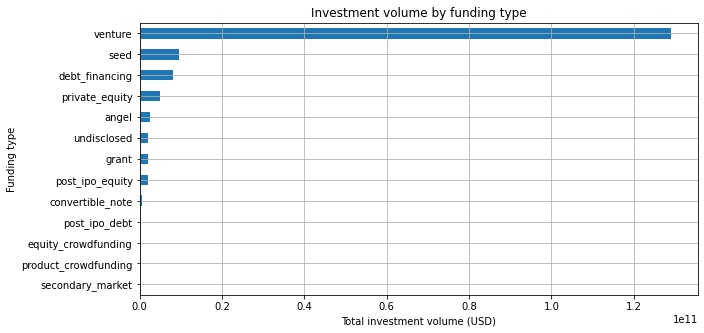

In [47]:
plt.figure (figsize = (10,5))
df_investments[columns].sum().sort_values(ascending=True).plot(
                kind='barh',
                title='Investment volume by funding type',
                rot=0,
                legend=False)
plt.ylabel('Funding type')
plt.xlabel('Total investment volume (USD)')
plt.grid()
plt.show()

In [48]:
df_investments[df_investments[columns] != 0][columns].count().sort_values(ascending=False)

venture                 18818
seed                    13369
debt_financing           3266
angel                    2935
grant                    1002
undisclosed               813
private_equity            634
convertible_note          521
equity_crowdfunding       515
product_crowdfunding      204
post_ipo_equity           164
post_ipo_debt              27
secondary_market            7
dtype: int64

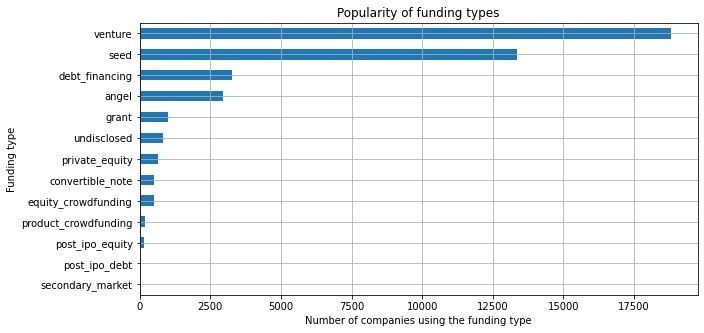

In [49]:
plt.figure (figsize = (10,5))
df_investments[df_investments[columns] != 0][columns].count().sort_values(ascending=True).plot(
                kind='barh',
                title='Popularity of funding types',
                rot=0,
                legend=False)
plt.ylabel('Funding type')
plt.xlabel('Number of companies using the funding type')
plt.grid()
plt.show()

The top 3 funding types rank the same both by total investment volume and by popularity: **venture** (leading by a wide margin), followed by **seed** and **debt financing**.

The 4th and 5th most popular funding types in terms of the number of companies — **angel** and **grant** — account for a relatively small share of total investment volume, ranking 5th and 7th respectively by funding amount.

Among less frequently used funding types, **private equity** stands out: despite ranking only 6th in popularity, it ranks 4th by total investment volume.

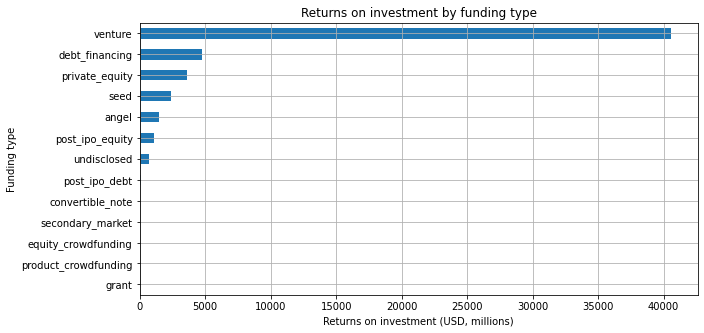

In [50]:
plt.figure (figsize = (10,5))
df_returns[columns].sum().sort_values(ascending=True).plot(
                kind='barh',
                title='Returns on investment by funding type',
                rot=0,
                legend=False)
plt.ylabel('Funding type')
plt.xlabel('Returns on investment (USD, millions)')
plt.grid()
plt.show()

The ranking by **investment returns** differs slightly from the ranking by funding volume and popularity. **Venture** remains the leading funding type by a wide margin. It is followed by **debt financing**, **private equity**, **seed**, and **angel** investments. Notably, **seed**, which ranks second both by total funding volume and by popularity, is only 4th in terms of returns. In contrast, **private equity** stands out as the third most profitable funding type, despite ranking only 7th by popularity and 4th by total funding volume.

<a id='trend-and-dynamics-analysis'></a>
## 4. Trend and dynamics analysis

### 4.1 Dynamics of funding over time

We calculate the average funding amount per round to analyze funding dynamics over time:

In [51]:
df_investments['funding_per_round'] = df_investments['funding_total_usd'] / df_investments['funding_rounds']

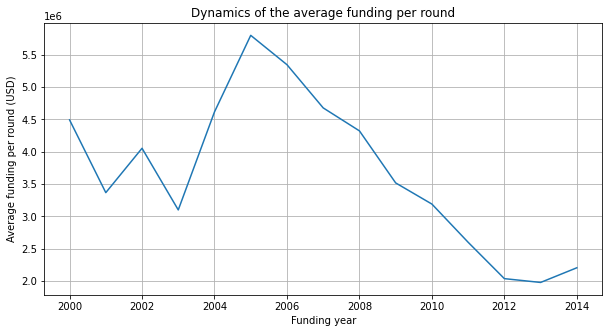

In [52]:
plt.figure (figsize = (10,5))
df_investments.groupby('year')['funding_per_round'].mean().plot(
                x='year',
                y='funding_per_round',
                kind='line',
                title='Dynamics of the average funding per round',
                rot=0,
                legend=False)
plt.xlabel('Funding year')
plt.ylabel('Average funding per round (USD)')
plt.grid()
plt.show()

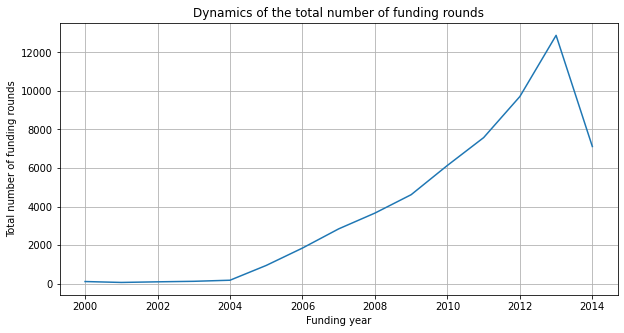

In [53]:
plt.figure (figsize = (10,5))
df_investments.groupby('year')['funding_rounds'].sum().plot(
                x='year',
                y='funding_rounds',
                kind='line',
                title='Dynamics of the total number of funding rounds',
                rot=0,
                legend=False)
plt.xlabel('Funding year')
plt.ylabel('Total number of funding rounds')
plt.grid()
plt.show()

The typical size of a single funding round was highest in 2005 and then showed a downward trend through 2013.

At the same time, the total number of funding rounds followed an opposite pattern, growing from 2004 to 2013 before entering a downturn.  

From 2005 to 2013, the average funding per round decreased. In 2014, this decline stopped, while the total number of funding rounds fell.

### 4.2 Dynamics of total funding in mass-market segments with growth in 2014

We create a pivot table aggregating total funding volumes by market and year.

The analysis then focuses on mass-market segments that experienced an increase in total funding in 2014 relative to 2013.

In [54]:
pivot_funding = pd.pivot_table(
    df_investments,
    index='market',
    columns='year',
    values='funding_total_usd',
    aggfunc='sum')
pivot_funding

year,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0
market,,,,,,,,,,,,,,,
advertising,14470000.0,8778321.0,24500000.0,10500000.0,6000000.0,127196022.0,2.992995e+08,5.567043e+08,6.226735e+08,5.634460e+08,6.316179e+08,4.107307e+08,5.211370e+08,5.249151e+08,2.077923e+08
analytics,14822803.0,NaN,7500000.0,3840000.0,3000000.0,79014044.0,1.397013e+08,9.882900e+07,2.080778e+08,1.409493e+08,2.537399e+08,4.433334e+08,5.392143e+08,6.228214e+08,1.514616e+08
apps,NaN,NaN,NaN,NaN,NaN,NaN,1.310600e+06,NaN,4.300000e+06,7.219000e+06,6.123779e+06,1.837407e+07,3.260112e+07,2.886862e+07,6.623773e+07
automotive,NaN,NaN,NaN,4530000.0,NaN,22500000.0,1.266000e+07,3.771260e+07,5.947864e+07,2.080031e+07,1.769692e+07,7.645216e+07,3.555768e+07,1.175725e+08,6.903416e+07
big data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.780000e+06,2.452515e+06,5.973750e+05,3.923330e+07,6.036916e+07,8.641334e+07,7.869892e+07,7.923260e+07
biotechnology,NaN,NaN,NaN,85531178.0,97184859.0,480063583.0,9.035005e+08,1.704078e+09,1.716033e+09,3.915901e+09,4.894500e+09,4.967552e+09,4.931139e+09,5.694270e+09,2.509639e+09
clean technology,NaN,NaN,34390435.0,50352939.0,50427954.0,19420000.0,1.314739e+08,7.497112e+08,3.165808e+09,1.963503e+09,1.604429e+09,1.545603e+09,9.580112e+08,1.203061e+09,6.886868e+08
cloud computing,11500000.0,NaN,NaN,NaN,NaN,NaN,9.951809e+06,2.035434e+07,4.437500e+07,5.222372e+07,8.525538e+06,7.315140e+07,7.442158e+07,8.484678e+07,7.344086e+07
consulting,4500000.0,NaN,NaN,NaN,NaN,44862000.0,2.396555e+07,7.034634e+07,1.906108e+07,6.271516e+07,8.126488e+07,4.341340e+07,6.592276e+07,9.332132e+07,5.429802e+07


In [55]:
pivot_funding = pivot_funding[pivot_funding[2014] > pivot_funding[2013]]
pivot_funding = pivot_funding.drop(['mid', 'niche','unknown'], errors='ignore') 
pivot_funding

year,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0
market,,,,,,,,,,,,,,,
apps,NaN,NaN,NaN,NaN,NaN,NaN,1310600.0,NaN,4300000.0,7219000.0,6123779.0,18374071.0,32601125.0,28868621.0,66237730.0
big data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7780000.0,2452515.0,597375.0,39233297.0,60369158.0,86413341.0,78698922.0,79232600.0
design,NaN,NaN,NaN,NaN,NaN,9300000.0,707000.0,10800000.0,5944302.0,2150144.0,17239975.0,8899967.0,39630692.0,60958835.0,68988516.0
internet,10000000.0,NaN,1100000.0,NaN,10500000.0,1775000.0,5000.0,4495379.0,23412964.0,38195773.0,36657500.0,36859032.0,28288685.0,69732096.0,117830756.0
manufacturing,56659310.0,2368582.0,NaN,4269608.0,3000000.0,61770000.0,163957751.0,147726051.0,173054260.0,422862531.0,244329661.0,561639285.0,522205168.0,393936634.0,416332314.0
medical,24000000.0,NaN,NaN,NaN,NaN,11090000.0,20250000.0,2100000.0,28812744.0,11566200.0,25590338.0,28540962.0,44039600.0,64469424.0,175236064.0
real estate,2500000.0,NaN,5275000.0,6292200.0,NaN,250000.0,2080000.0,33220000.0,46613100.0,38840213.0,37344608.0,20015128.0,77320857.0,92207655.0,115567364.0
saas,NaN,NaN,2000000.0,NaN,NaN,5240000.0,4791121.0,14652595.0,27226900.0,13536585.0,32609390.0,32223749.0,49699912.0,79576613.0,92807752.0
startups,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5010387.0,460700.0,2111966.0,19654403.0,12358782.0,18080552.0,41501837.0


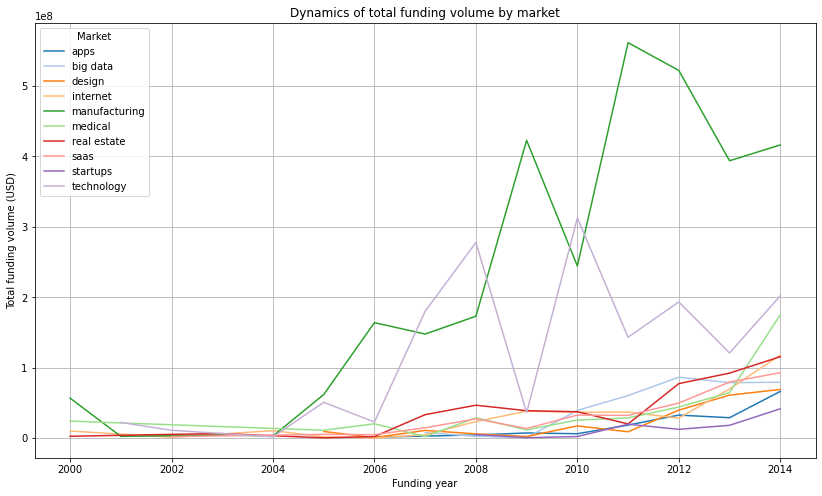

In [56]:
plt.figure(figsize=(14,8))

df_pivot = pivot_funding.reset_index().melt(id_vars='market', var_name='year', value_name='funding')

sns.lineplot(data=df_pivot, x='year', y='funding', hue='market', palette='tab20')

plt.title('Dynamics of total funding volume by market')
plt.xlabel('Funding year')
plt.ylabel('Total funding volume (USD)')
plt.grid()
plt.legend(title='Market')
plt.show()

Among the fast-growing markets, the most notable are **technology** and **medical** (which shows the strongest growth in 2014 compared to 2013), as well as **internet** (demonstrating steady growth since 2012), **real estate**, **apps**, **startups**, **manufacturing**. Other markets demonstrate more moderate growth dynamics.

### 4.3 Annual dynamics of investment return share by funding type

For each year and funding type, we calculate the return ratio, defined as returned capital divided by total invested capital:

In [57]:
returns_by_year = df_returns.groupby('year')[columns].sum().sort_index() * 1000000
returns_by_year

,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding
year,,,,,,,,,,,,,
2000,16700000.0,5.540000e+07,0.0,78210000.0,0.0,8.660000e+06,6430000.0,0.0,0.0,940000.0,0.0,200000.0,0.0
2001,2880000.0,2.349000e+07,0.0,21500000.0,10000.0,4.490000e+06,1180000.0,0.0,0.0,460000.0,0.0,460000.0,0.0
2002,6590000.0,2.094200e+08,0.0,25770000.0,20000.0,3.420000e+06,3410000.0,0.0,1510000.0,340000.0,0.0,60000.0,0.0
2003,7740000.0,2.338600e+08,0.0,9400000.0,10000.0,1.090000e+06,3410000.0,0.0,1620000.0,2110000.0,0.0,80000.0,0.0
2004,9930000.0,5.559000e+08,0.0,33190000.0,10000.0,1.355000e+07,9180000.0,0.0,2190000.0,3380000.0,0.0,550000.0,0.0
2005,26600000.0,2.628920e+09,0.0,9510000.0,20000.0,3.509000e+07,31060000.0,0.0,2400000.0,3510000.0,0.0,50000.0,0.0
2006,61810000.0,3.100180e+09,190000.0,46740000.0,1780000.0,1.132100e+08,47750000.0,0.0,16670000.0,20580000.0,0.0,120000.0,0.0
2007,70410000.0,3.585370e+09,10000.0,55370000.0,3220000.0,1.256800e+08,164510000.0,0.0,88810000.0,24360000.0,0.0,570000.0,0.0
2008,89720000.0,2.717020e+09,30000.0,41020000.0,1710000.0,3.975400e+08,102830000.0,0.0,130380000.0,84280000.0,0.0,470000.0,0.0


In [58]:
funding_by_year = df_investments[df_investments['year'] != 1999].groupby('year')[columns].sum().sort_index()
funding_by_year

,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding
year,,,,,,,,,,,,,
2000.0,1.675914e+07,3.279622e+08,0.0,112202640.0,0.0,1.400000e+07,24086333.0,293114.0,0.000000e+00,3467747.0,0.0,7718867.0,0.0
2001.0,2.667675e+06,2.175191e+08,0.0,36596784.0,1500000.0,5.829217e+06,1000000.0,100000.0,0.000000e+00,0.0,0.0,0.0,0.0
2002.0,1.046519e+07,3.069406e+08,0.0,42323731.0,0.0,1.530967e+07,3000000.0,0.0,7.500000e+06,300000.0,0.0,0.0,0.0
2003.0,1.531836e+07,3.722344e+08,0.0,10280000.0,0.0,1.050000e+06,5629661.0,16850717.0,0.000000e+00,0.0,0.0,0.0,0.0
2004.0,1.810473e+07,6.641505e+08,0.0,62912359.0,0.0,3.081662e+07,11013741.0,10363600.0,0.000000e+00,0.0,0.0,0.0,0.0
2005.0,3.942520e+07,4.809711e+09,0.0,8871332.0,0.0,1.017207e+08,60914621.0,6266481.0,5.000000e+06,4796022.0,0.0,0.0,0.0
2006.0,6.679477e+07,9.020604e+09,933057.0,61545498.0,10702385.0,1.408484e+08,70756153.0,6147500.0,1.782024e+07,0.0,0.0,0.0,0.0
2007.0,1.922965e+08,1.207069e+10,0.0,109649902.0,14116788.0,2.116016e+08,201152441.0,34237779.0,1.533702e+08,12000000.0,0.0,0.0,0.0
2008.0,3.020030e+08,1.423473e+10,0.0,119920337.0,28600902.0,4.286221e+08,249299613.0,23485347.0,1.917563e+08,36000000.0,0.0,0.0,1000000.0


In [59]:
returns_share = returns_by_year / (funding_by_year + 1e-60)
returns_share

,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding
year,,,,,,,,,,,,,
2000,0.996471,0.168922,0.000000e+00,0.697042,0.000000e+00,0.618571,0.266956,0.0,0.000000e+00,2.710694e-01,0.000000,2.591054e-02,0.000000
2001,1.079592,0.107991,0.000000e+00,0.587483,6.666667e-03,0.770258,1.180000,0.0,0.000000e+00,4.600000e+65,0.000000,4.600000e+65,0.000000
2002,0.629707,0.682282,0.000000e+00,0.608878,2.000000e+64,0.223388,1.136667,0.0,2.013333e-01,1.133333e+00,0.000000,6.000000e+64,0.000000
2003,0.505276,0.628260,0.000000e+00,0.914397,1.000000e+64,1.038095,0.605720,0.0,1.620000e+66,2.110000e+66,0.000000,8.000000e+64,0.000000
2004,0.548476,0.837009,0.000000e+00,0.527559,1.000000e+64,0.439698,0.833504,0.0,2.190000e+66,3.380000e+66,0.000000,5.500000e+65,0.000000
2005,0.674695,0.546586,0.000000e+00,1.071992,2.000000e+64,0.344964,0.509894,0.0,4.800000e-01,7.318565e-01,0.000000,5.000000e+64,0.000000
2006,0.925372,0.343678,2.036317e-01,0.759438,1.663181e-01,0.803772,0.674853,0.0,9.354530e-01,2.058000e+67,0.000000,1.200000e+65,0.000000
2007,0.366153,0.297031,1.000000e+64,0.504971,2.280972e-01,0.593946,0.817837,0.0,5.790563e-01,2.030000e+00,0.000000,5.700000e+65,0.000000
2008,0.297083,0.190873,3.000000e+64,0.342060,5.978832e-02,0.927484,0.412476,0.0,6.799254e-01,2.341111e+00,0.000000,4.700000e+65,0.000000


In [60]:
def replace_outliers (column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + IQR*1.5
    lower_limit = Q1 - IQR*1.5
    column[(column < lower_limit) | (column > upper_limit)] = np.nan
    return column
      
returns_share = returns_share.apply(replace_outliers, axis=0)

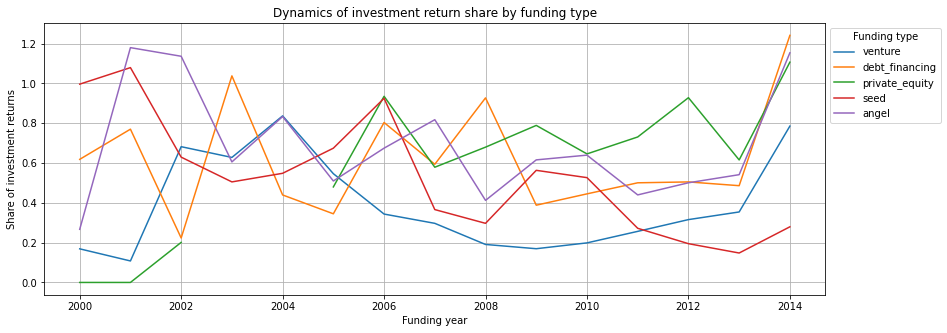

In [61]:
returns_share[['venture','debt_financing','private_equity','seed','angel']].plot(
                kind='line',
                title='Dynamics of investment return share by funding type',
                rot=0,
                figsize = (14,5))
plt.xlabel('Funding year')
plt.ylabel('Share of investment returns')
plt.grid()
plt.legend(title='Funding type', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In 2014, investment returns exceeded invested capital for only three funding types: `debt_financing`, `private_equity` and `angel`. Although `venture` financing leads in terms of total return volume, its returns did not exceed the amount invested throughout the observed period. That said, the return-to-investment ratio for venture financing has been improving since 2013 and came close to breakeven in 2014.

<a id='final-conclusions-and-recommendations'></a>
## 5. Final conclusions and recommendations

We analyzed data on 54,294 startups that received funding between 1999 and 2014. The dataset includes a wide range of company characteristics, as well as detailed information on funding activity: total funding raised, number of funding rounds, funding timelines, funding types, investment returns. 

The goal of the analysis was to examine the dynamics and structure of startup funding and to support investors in assessing market entry opportunities through company acquisition and development.

### 5.1 Descriptive overview of startup funding

- **Funding timelines:** Around 60% of startups raised funding only once, accounting for ~30% of total invested capital. In contrast, startups with funding timelines longer than one year represent 30% of all companies but attracted more than 60% of total investments. Short-term funded startups (under one year) form the smallest group both by count (10%) and by capital raised (less than 10%).

- **Market segments:** The top 10 most represented markets are software (4,812 companies), biotechnology (3,590), mobile (2,343), e-commerce (1,866), curated web (1,691), enterprise software (1,381), health care (1,185), clean technology (1,180), games (1,117), and advertising (1,107). Overall, 88.8% of startups operate in mass-market segment (markets with more than 120 companies), indicating a strong concentration of companies in a limited number of large markets.

- **Typical funding size:** A typical company raises between USD 350,000 and USD 24,000,000 in total funding, with a median of approximately USD 2,000,000. The distribution is heavily right-skewed, with extreme outliers reaching billions of dollars, particularly in real estate, entertainment, consulting, search, and cloud computing.

- **Funding types:** Venture, seed, and debt financing dominate both in terms of total investment volume and adoption. By investment returns, venture remains the leader, followed by debt financing and private equity. Notably, private equity ranks high in returns despite relatively low popularity.

- **Funding rounds:** From 2005 to 2013, the average size of a funding round declined while the total number of rounds increased. In 2014, this pattern shifted: the total number of rounds decreased, and the decline in average round size stabilized.

- **Market growth:** The fastest-growing markets include technology, medical (the strongest growth in 2014 vs. 2013), internet, real estate, apps, and startups.

- **Investment returns:** In 2014, only debt financing, angel and private equity generated returns exceeding invested capital. Although venture funding leads in absolute returns, it has not consistently outperformed invested capital, though the gap narrowed significantly by 2014.


### 5.2 Recommendations

Investors may consider focusing on **fast-growing markets**, such as *technology, medical, internet,* and *apps*.

The **mass-market segment**, which accounts for nearly **90% of all companies**, appears to be the most stable and predictable segment for investment.

In terms of **funding types**, *debt financing* and *private equity* stand out as the most profitable when measured by the share of investment returns. At the same time, *venture capital* shows a steady increase in return share and continues to lead in both total investment volume and popularity, making it a reasonable option as well.

Regarding **funding timelines**, companies with a funding duration of **more than one year** are preferable, as they attracted the majority of total investments (around 60%).

Finally, in terms of **investment size**, investors should primarily target deals in the range of **USD 350,000 to USD 24,000,000**, which represents the typical funding range for most companies.